In [45]:
import os
import re
import sys
import json
import glob
import pickle
from datetime import datetime
import subprocess
from collections import Counter

import numpy as np
import pandas as pd

from nltk.corpus import stopwords as sw

import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

from sklearn import metrics

from pynlpl.formats import folia

# Customs
import get_folia_tokens as gft

%matplotlib inline

In [2]:
def getAnnotatedDocs(inputfolder, foliaset):
    return [xfile for xfile in glob.glob(inputfolder +"/*.folia.xml") if folia.Document(file=xfile).declared(folia.Entity, foliaset)]

In [3]:
inputfolder = "../EIFD/data/EIFD-FlatData"
mbtFolder = 'data/MBTData/'
foliaset = 'https://raw.githubusercontent.com/ErkanBasar/mebasarcom/master/eifd.foliaset.xml'

In [4]:
annotdocs = getAnnotatedDocs(inputfolder, foliaset)

In [5]:
splt = int((50 * len(annotdocs)) / 100.0)
splt

22

In [6]:
trainlist = annotdocs[:splt]
testlist = annotdocs[splt:]

## Feature Extraction

In [11]:
notstop = ['this', 'until', 'about', 'above' , 'over' , 'under' , 'more', 'some', 'few', 'than', 'now', 'at']
stopwords = [word for word in sw.words('english') if word not in notstop]

In [12]:
excludedclasses = ['dmg.bus', 'dmg.ppl.inj', 'dmg.econ', 'dmg.ppl.miss', 'dmg.ppl.evac', 'dmg.ppl.kill', 'dmg.prop', 'resp.donat', 'resp.supply']

In [18]:
class Token(object):
    
    def __init__(self, folia_obj):
        self.obj = folia_obj
        
        self.cls = "O"
        self.ner = "---"
        self.previous = None
        self.next = None
        
        if(self.obj is None):
            self.foliaId = "---"
            self.text = "---"
            self.pos = "---"
        else:
            self.foliaId = self.obj.id
            self.text = self.obj.text()
            self.pos = self.obj.pos()


    def getClass(self):
        if(self.obj is not None):
            for entity in self.obj.findspans(folia.Entity):
                if(entity.annotatortype == folia.AnnotatorType.MANUAL):
                    if(entity.cls not in excludedclasses):
                        if(entity.cls == 'loc.other'):
                            entityclass = 'loc.focus' 
                        else:
                            entityclass = entity.cls 
                        self.cls = "B." + entityclass
                        if(self.previous == None):
                            self.cls = "B." + entityclass 
                        else:
                            for prevEntity in self.previous.findspans(folia.Entity):
                                if(entity.id == prevEntity.id and prevEntity.annotatortype == folia.AnnotatorType.MANUAL):
                                    self.cls = "I." + entityclass
        return self.cls
    
    def getNer(self):
        if(self.obj is not None):
            for entity in self.obj.findspans(folia.Entity):
                if(entity.annotator == 'nltk-stanford'):
                    self.ner = entity.cls
        return self.ner
    
    def getPrevious(self):
        if self.obj is not None and self.obj.previous(folia.Word, [folia.Sentence]) is not None:
            self.previous = self.obj.previous(folia.Word, [folia.Sentence])
        return self.previous
    
    def getNext(self):
        if self.obj is not None and self.obj.next(folia.Word, [folia.Sentence]) is not None:
            self.next = self.obj.next(folia.Word, [folia.Sentence])
        return self.next
    
    def kill(self):
        del self

In [19]:
def createLine(token, classProb):
    
    #features = {}
    
    # Object Initialization
    prevToken = Token(token.getPrevious())
    #prevPrevToken = Token(prevToken.getPrevious())
    #nextToken = Token(token.getNext())
    #nextNextToken = Token(nextToken.getNext())
    
    # Add class probabilities of the sentence
    #features.update(classProb)
    
    # Token 
    #features['pos'] = token.pos
    #features['ner'] = token.getNer()
    
    # Previous (-1)
    #features['-1:pos'] = prevToken.pos
    #features['-1:ner'] = prevToken.getNer()    

    # Next (+1)
    #features['+1:pos'] = nextToken.pos
    #features['+1:ner'] = nextToken.getNer()  
    
    # Previous (-2)
    #features['-2:pos'] = prevPrevToken.pos
    #features['-2:ner'] = prevPrevToken.getNer()  

    # Next (+2)
    #features['+2:pos'] = nextNextToken.pos
    #features['+2:ner'] = nextNextToken.getNer() 
    
    #features['foliaId'] = token.foliaId 
    
    line = token.text + ' ' + token.pos + ' ' + token.getNer() + ' '
    #for k,v in features.items():
    #    line += str(v) + ' '
    
    line = line + str(token.getClass()) + '\n'
    return line

In [26]:
doc = folia.Document(file=annotdocs[0])
createLine(Token(doc['content0.p.1.s.1.w.1']), [], test=False)

'Floods NNS --- B.event.flood\n'

In [17]:
def createMBTFile(filelist, outfilepath, testrun=False):
    
    #allClasses = pickle.load(open("data/Classifiers/sentenceBinarizer.pickle", "rb")).classes_
    #possibleCVLabels = pickle.load(open("data/Classifiers/possibleCVLabels.pickle", "rb"))
    #sentenceClassifier = pickle.load(open("data/Classifiers/sentenceClassifier.pickle", "rb"))
    
    filelist = [filelist] if(type(filelist) == str) else filelist

    if(type(filelist) == list and len(filelist) >= 1):
        
        outfile = open(outfilepath, "w")

        for filepath in filelist:
            for doc in folia.Document(file=filepath):
                for sentence in doc.sentences():
                    
                    #possibleLabels = possibleCVLabels[sentence.id]
                    #possibleLabels = sentenceClassifier.decision_function([sentence.id])[0]
                    classProb = []#dict(zip(allClasses, possibleLabels))
                    
                    #for cls in excludedclasses:
                    #    if cls in classProb:
                    #        del classProb[cls]
                    #del classProb['loc.other']
                    
                    for word in sentence.words():
                        
                            #if word.text().lower() not in stopwords:
                            
                                token = Token(word)

                                tokenClass = token.getClass()

                                if(testrun is True):
                                    if(tokenClass != "O"):
                                        outfile.write(createLine(token, classProb))
                                else:
                                    outfile.write(createLine(token, classProb))

                    outfile.write("<utt>\n")
                    
            #print(filepath)

        outfile.close()
    else:
        print('Input may be wrong. It should be a list of file paths or a single string file path.')
        print('Input type you tried: ' + str(type(filelist)))
        sys.exit()

In [52]:
createMBTFile(trainlist, 'data/MBTData/MBTTrain.data')

In [54]:
createMBTFile(testlist, 'data/MBTData/MBTTest.data')

## Run MBT

In [55]:
p = subprocess.Popen(["mbtg","-E","MBTTrain.data","-p","dwdwfWawaw","-P","cndwdwFawaw"], cwd="data/MBTData")
p.wait()

0

In [56]:
testOut = open('data/MBTData/test.out', 'w') 
p = subprocess.Popen(["mbt","-s","MBTTrain.data.settings","-E","MBTTest.data"], stdout=testOut, cwd="data/MBTData")
p.wait()

0

## Evaluation

In [57]:
def integerizeLabels(y, labels, algorithm=None):
    '''Maps the labels in a list to their corresponding indexes in unique label list.'''
    int_list = []
    labels_o = labels.copy()
    labels_o.append('O')
    for cls in y:
        int_list.append(labels_o.index(cls))    
    return int_list

In [58]:
def singleEvalGraphs(Y, P, labels):
    Yint = integerizeLabels(Y, labels, algorithm=None)
    Pint = integerizeLabels(P, labels, algorithm=None)
    skplt.plot_confusion_matrix(Yint, Pint, normalize=True, figsize=(12,12))
    labels = sorted([label for label in list(set(Y)) if label not in ['O']])
    print(metrics.classification_report(Y, P, labels=labels))
    plt.show()

In [64]:
testOut = open('data/MBTData/test.out', "r")
lines = testOut.readlines()
Y = []
predictions = []
for line in lines[7:]:
    #print(line)
    spacesplt = line.split("\n")[0]
    #print(spacesplt)
    tabsplt = spacesplt.split("\t")
    if(len(tabsplt) > 1):
        #print(tabsplt)
        Y.append(tabsplt[-2])
        predictions.append(tabsplt[-1])
testOut.close()
Counter(Y)

Counter({'B.event.flood': 148,
         'B.loc.focus': 148,
         'B.loc.supp': 55,
         'B.time': 43,
         'I.event.flood': 68,
         'I.loc.focus': 43,
         'I.loc.supp': 20,
         'I.time': 28,
         'O': 20204})

In [65]:
trainf = open('data/MBTData/MBTTrain.data', "r")
lines = trainf.readlines()
Ytrain = []
for line in lines:
    spacesplt = line.split("\n")[0]
    tabsplt = spacesplt.split(" ")
    if(len(tabsplt) > 1):
        Ytrain.append(tabsplt[-1])
trainf.close()
Counter(Ytrain)

Counter({'B.event.flood': 144,
         'B.loc.focus': 102,
         'B.loc.supp': 46,
         'B.time': 53,
         'I.event.flood': 40,
         'I.loc.focus': 9,
         'I.loc.supp': 6,
         'I.time': 39,
         'O': 19408})

In [61]:
labels = sorted([label for label in list(set(Y)) if label not in ['O']])
labels

['B.event.flood',
 'B.loc.focus',
 'B.loc.supp',
 'B.time',
 'I.event.flood',
 'I.loc.focus',
 'I.loc.supp',
 'I.time']

               precision    recall  f1-score   support

B.event.flood       0.35      0.30      0.32       148
  B.loc.focus       0.35      0.23      0.28       148
   B.loc.supp       0.43      0.36      0.39        55
       B.time       0.28      0.26      0.27        43
I.event.flood       0.43      0.32      0.37        68
  I.loc.focus       0.25      0.09      0.14        43
   I.loc.supp       0.20      0.05      0.08        20
       I.time       0.12      0.11      0.12        28

  avg / total       0.34      0.25      0.28       553



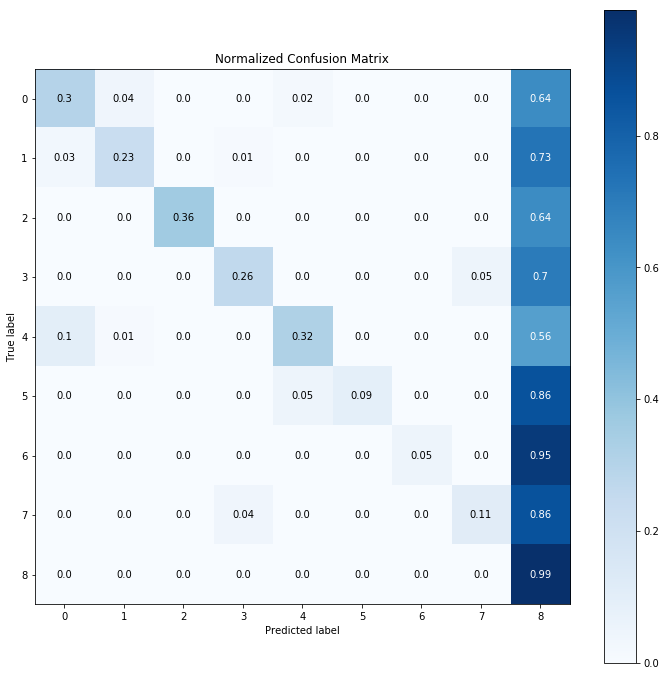

In [23]:
# %50 with PoS
singleEvalGraphs(Y, predictions, labels)

               precision    recall  f1-score   support

B.event.flood       0.41      0.41      0.41       148
  B.loc.focus       0.43      0.23      0.30       148
   B.loc.supp       0.38      0.35      0.36        55
       B.time       0.26      0.27      0.27        44
I.event.flood       0.58      0.28      0.38        68
  I.loc.focus       0.00      0.00      0.00        43
   I.loc.supp       0.67      0.10      0.17        20
       I.time       0.17      0.11      0.13        27

  avg / total       0.39      0.27      0.31       553



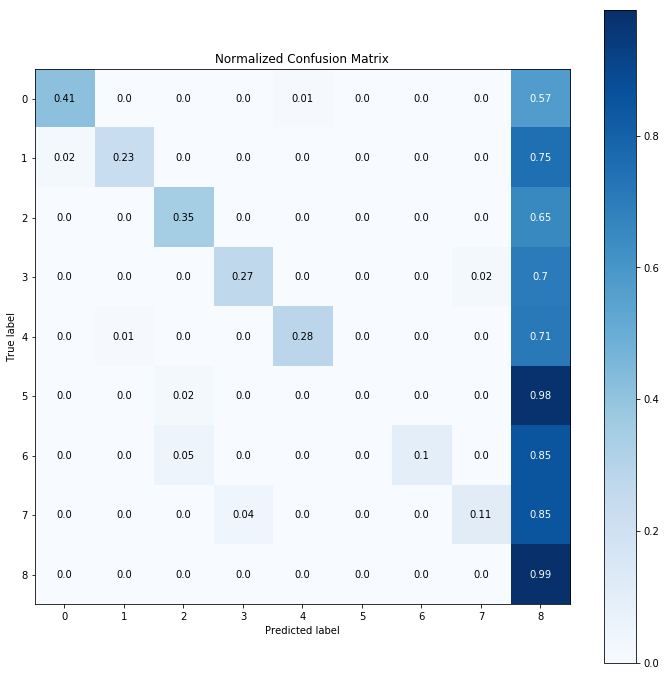

In [158]:
# %50 stopwords removed
singleEvalGraphs(Y, predictions, labels)